# Create Evidence tables

Create tables sumarizing evidence for model components.
## Setup
### Import packages

In [1]:
import requests
import pandas as pd

import matplotlib.pyplot as plt

from rbc_gem_utils import (
    COBRA_CONFIGURATION,
    ROOT_PATH,
    EXTERNAL_PATH,
    INTERIM_PATH,
    ANNOTATION_PATH,
    CURATION_PATH,
    compare_tables,
    visualize_comparison,
    get_annotation_df,
    show_versions,
    read_rbc_model,
    split_string,
    build_string,
)

# Display versions of last time notebook ran and worked
show_versions()


Package Information
-------------------
rbc-gem-utils 0.0.1

Dependency Information
----------------------
beautifulsoup4                       4.12.3
bio                                   1.6.2
cobra                                0.29.0
depinfo                               2.2.0
kaleido                               0.2.1
matplotlib                            3.8.2
memote                               0.17.0
networkx                              3.2.1
notebook                              7.0.7
openpyxl                              3.1.2
pandas                                2.2.0
pre-commit                            3.6.0
pyvis                                 0.3.2
rbc-gem-utils[database,network,vis] missing
requests                             2.31.0
scipy                                1.12.0
seaborn                              0.13.2

Build Tools Information
-----------------------
pip        23.3.1
setuptools 68.2.2
wheel      0.41.2

Platform Information
-------------------

### Define configuration
#### COBRA Configuration

In [2]:
COBRA_CONFIGURATION

Attribute,Description,Value
solver,Mathematical optimization solver,glpk
tolerance,"General solver tolerance (feasibility, integrality, etc.)",1e-07
lower_bound,Default reaction lower bound,-1000.0
upper_bound,Default reaction upper bound,1000.0
processes,Number of parallel processes,15
cache_directory,Path for the model cache,/Users/zhaiman/Library/Caches/cobrapy
max_cache_size,Maximum cache size in bytes,104857600
cache_expiration,Model cache expiration time in seconds (if any),None


## Load RBC-GEM model

In [3]:
model = read_rbc_model(filetype="xml")
model.reactions.sort()
model.genes.sort()
model.metabolites.sort()
model

Name,RBC_GEM
Memory address,14fe6fe90
Number of metabolites,1967
Number of reactions,2788
Number of genes,653
Number of groups,74
Objective expression,1.0*NaKt - 1.0*NaKt_reverse_db47e
Compartments,"cytosol, extracellular space"


## Load omic evidence
### Proteomic evidence

In [4]:
df_proteomic_evidence = pd.read_csv(
    f"{ROOT_PATH}{EXTERNAL_PATH}/proteomics/proteomic_evidence_table.tsv",
    sep="\t",
    index_col=0,
)
df_proteomic_evidence = pd.concat(
    (
        df_proteomic_evidence.sum(axis=1),
        pd.DataFrame.from_dict(
            {
                uniprot_id: build_string(
                    sorted(
                        [
                            f"pubmed:{pubmed}"
                            for pubmed, is_detected in value_dict.items()
                            if bool(is_detected)
                        ]
                    )
                )
                for uniprot_id, value_dict in df_proteomic_evidence.T.to_dict().items()
            },
            orient="index",
        ),
    ),
    axis=1,
)
df_proteomic_evidence.columns = [
    "proteomic evidence (#studies)",
    "proteomic evidence (pubmed)",
]
df_proteomic_evidence

,proteomic evidence (#studies),proteomic evidence (pubmed)
P04406,21,pubmed:16861337;pubmed:18399644;pubmed:1849451...
P04040,21,pubmed:16861337;pubmed:18399644;pubmed:1849451...
Q99832,20,pubmed:16861337;pubmed:18399644;pubmed:1849451...
P51148,20,pubmed:16861337;pubmed:18494517;pubmed:1861456...
P11142,20,pubmed:16861337;pubmed:18399644;pubmed:1849451...
...,...,...
Q15751,1,pubmed:33103907
Q15738,1,pubmed:28689405
Q15717,1,pubmed:37942280
Q15653,1,pubmed:18614565


### Create evidence tables

In [5]:
compare = True
overwrite = True

#### Genes

,genes,uniprot,ncbigene,hgnc.symbol,proteomic evidence (#studies),proteomic evidence (pubmed),references,notes
0,CAT,P04040,847,CAT,21,pubmed:16861337;pubmed:18399644;pubmed:1849451...,pubmed:16748387;pubmed:901548,NaN
1,GAPDH,P04406,2597,GAPDH,21,pubmed:16861337;pubmed:18399644;pubmed:1849451...,pubmed:19430704,NaN
2,HSPA8,P11142,3312,HSPA8,20,pubmed:16861337;pubmed:18399644;pubmed:1849451...,NaN,NaN
3,RAB5C,P51148,5878,RAB5C,20,pubmed:16861337;pubmed:18494517;pubmed:1861456...,NaN,NaN
4,ACLY,P53396,47,ACLY,19,pubmed:16861337;pubmed:18399644;pubmed:1861456...,pubmed:27813142,NaN
...,...,...,...,...,...,...,...,...
648,SCD,O00767,6319,SCD,0,NaN,pubmed:33904180,NaN
649,RPS6KA4,O75676,8986,RPS6KA4,0,NaN,pubmed:26611568,NaN
650,GCNT2,Q8N0V5,2651,GCNT2,0,NaN,pubmed:29662110,NaN
651,GRIA1,P42261,2890,GRIA1,0,NaN,pubmed:19320779,NaN


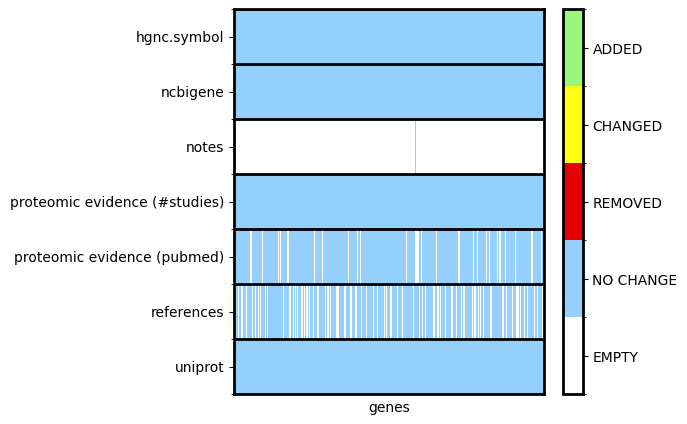

In [6]:
attribute_type = "genes"
try:
    df_previous_evidence = pd.read_csv(
        f"{ROOT_PATH}{CURATION_PATH}/{attribute_type}_evidence.tsv",
        sep="\t",
        index_col=0,
        dtype=str,
    )
except FileNotFoundError:
    df_previous_evidence = pd.DataFrame([], columns=[attribute_type], dtype=str)

annotation_key = ["uniprot", "ncbigene", "hgnc.symbol"]
df_evidence = get_annotation_df(getattr(model, attribute_type), annotation_key)
df_evidence = df_evidence.rename({"id": attribute_type}, axis=1).set_index(
    attribute_type
)
df_evidence = df_evidence.merge(
    df_proteomic_evidence,
    left_on="uniprot",
    right_index=True,
    how="left",
)
df_evidence["proteomic evidence (#studies)"] = (
    df_evidence["proteomic evidence (#studies)"].fillna(0).astype(int)
)
df_evidence["references"] = df_previous_evidence.set_index(attribute_type)["references"]
df_evidence["references"] = (
    df_evidence["references"]
    .fillna("")
    .apply(lambda x: build_string(sorted(split_string(x))))
)
df_evidence["notes"] = df_previous_evidence.set_index(attribute_type)["notes"]

df_evidence = df_evidence.sort_index(ascending=True)
df_evidence = df_evidence.sort_values(
    by=["proteomic evidence (#studies)"], ascending=[False]
)
df_evidence = df_evidence.reset_index(drop=False).replace("", float("nan"))
df_references = df_evidence[[attribute_type, "references"]].copy()

if compare:
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    df_comparision = compare_tables(
        df_previous_evidence.set_index(attribute_type),
        df_evidence.set_index(attribute_type),
    )
    ax = visualize_comparison(df_comparision)

if overwrite:
    df_evidence.to_csv(
        f"{ROOT_PATH}{CURATION_PATH}/{attribute_type}_evidence.tsv", sep="\t"
    )
    df_references.to_csv(
        f"{ROOT_PATH}{ANNOTATION_PATH}/{attribute_type}_References.tsv", sep="\t"
    )
else:
    df_evidence.to_csv(
        f"{ROOT_PATH}{INTERIM_PATH}/{attribute_type}_evidence.tsv", sep="\t"
    )
    df_references.to_csv(
        f"{ROOT_PATH}{INTERIM_PATH}/{attribute_type}_References.tsv", sep="\t"
    )

model_proteomics_count = df_evidence.set_index("genes")[
    "proteomic evidence (#studies)"
].to_dict()
df_evidence

#### Reactions

,reactions,name,reaction,gene reaction rule,subsystem,spontaneous,proteomic evidence (#studies),references,notes
0,FACOAE_10_0,Acyl CoA thioesterase (CoA 10:0),FAcoa_hs_10_0_c + h2o_c --> FA_hs_10_0_c + coa...,ACOT7,Acyl-CoA hydrolysis,0,ACOT7 (11),pubmed:10578051;pubmed:5042454,NaN
1,FACOAE_11_0,Acyl CoA thioesterase (CoA 11:0),FAcoa_hs_11_0_c + h2o_c --> FA_hs_11_0_c + coa...,ACOT7,Acyl-CoA hydrolysis,0,ACOT7 (11),pubmed:10578051;pubmed:5042454,NaN
2,FACOAE_12_0,Acyl CoA thioesterase (CoA 12:0),FAcoa_hs_12_0_c + h2o_c --> FA_hs_12_0_c + coa...,ACOT7 or MBLAC2,Acyl-CoA hydrolysis,0,ACOT7 (11);MBLAC2 (9),pubmed:10578051;pubmed:5042454,NaN
3,FACOAE_13_0,Acyl CoA thioesterase (CoA 13:0),FAcoa_hs_13_0_c + h2o_c --> FA_hs_13_0_c + coa...,ACOT7 or MBLAC2,Acyl-CoA hydrolysis,0,ACOT7 (11);MBLAC2 (9),pubmed:10578051;pubmed:5042454,NaN
4,FACOAE_14_0,Acyl CoA thioesterase (CoA 14:0),FAcoa_hs_14_0_c + h2o_c --> FA_hs_14_0_c + coa...,ACOT7 or MBLAC2,Acyl-CoA hydrolysis,0,ACOT7 (11);MBLAC2 (9),pubmed:10578051;pubmed:5042454,NaN
...,...,...,...,...,...,...,...,...,...
2376,PYDXPP,Pyridoxal 5-phosphate phosphatase,h2o_c + pydx5p_c --> pi_c + pydx_c,PDXP,Vitamin B6 metabolism,0,PDXP (16),pubmed:1322411;pubmed:14522954;pubmed:7448195;...,NaN
2377,AVITE1RASCBR1,Reduction of alpha-tocopherol radical via L-as...,ascb__L_c + avite1r_c <=> avite1_c + mdhdascb_...,NaN,Vitamin E metabolism,1,NaN,pubmed:18243141;pubmed:36643550;pubmed:8388377...,NaN
2378,AVITE1RCYTB5R,Reduction of alpha-tocopherol radical via L-as...,avite1r_c + focytb5_c + h_c --> avite1_c + fic...,CYB5R3 or (CYB5R3 and CYB5B) or (CYB5R3 and CY...,Vitamin E metabolism,0,CYB5A (8);CYB5B (8);CYB5R3 (19),pubmed:8388377,NaN
2379,AVITE1RQ10H2R,Reduction of alpha-tocopherol radical via ubiq...,avite1r_c + q10h2_c --> avite1_c + q10h_c,NaN,Vitamin E metabolism,1,NaN,pubmed:8388377;pubmed:8434935,NaN


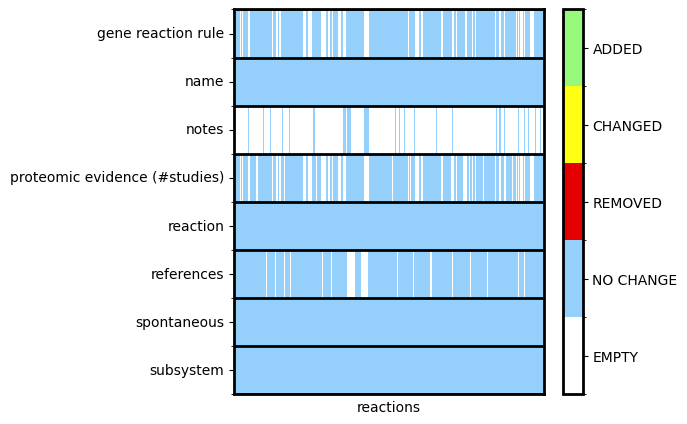

In [7]:
attribute_type = "reactions"
try:
    df_previous_evidence = pd.read_csv(
        f"{ROOT_PATH}{CURATION_PATH}/{attribute_type}_evidence.tsv",
        sep="\t",
        index_col=0,
        dtype=str,
    )
except FileNotFoundError:
    df_previous_evidence = pd.DataFrame([], columns=[attribute_type], dtype=str)

df_evidence = pd.DataFrame.from_dict(
    {
        idx: {
            f"{attribute_type}": reaction.id,
            "name": reaction.name,
            "reaction": reaction.reaction,
            "gene reaction rule": reaction.gene_reaction_rule,
            "subsystem": reaction.subsystem,
            "spontaneous": reaction.annotation.get("spontaneous", 0),
            "proteomic evidence (#studies)": build_string(
                sorted(
                    [
                        "{} ({})".format(gene.id, model_proteomics_count[gene.id])
                        for gene in list(reaction.genes)
                        if model_proteomics_count[gene.id] != 0
                    ]
                )
            ),
        }
        for idx, reaction in enumerate(model.reactions.query(lambda x: not x.boundary))
    },
    orient="index",
)
df_evidence = df_evidence.set_index(attribute_type)
# Preserve reactions marked spontaneous based on reference data
df_evidence["spontaneous"] = df_previous_evidence.set_index(attribute_type)[
    "spontaneous"
]
df_evidence["references"] = df_previous_evidence.set_index(attribute_type)["references"]
df_evidence["references"] = (
    df_evidence["references"]
    .fillna("")
    .apply(lambda x: build_string(sorted(split_string(x))))
)
df_evidence["notes"] = df_previous_evidence.set_index(attribute_type)["notes"]
df_evidence = df_evidence.reset_index(drop=False).sort_values(
    by=["subsystem", "reactions"], ascending=[True, True]
)
df_evidence = df_evidence.reset_index(drop=True).replace("", float("nan"))
df_references = df_evidence[[attribute_type, "spontaneous", "references"]].copy()

if compare:
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    df_comparision = compare_tables(
        df_previous_evidence.set_index(attribute_type),
        df_evidence.set_index(attribute_type),
    )
    ax = visualize_comparison(df_comparision)

if overwrite:
    df_evidence.to_csv(
        f"{ROOT_PATH}{CURATION_PATH}/{attribute_type}_evidence.tsv", sep="\t"
    )
    df_references.to_csv(
        f"{ROOT_PATH}{ANNOTATION_PATH}/{attribute_type}_References.tsv", sep="\t"
    )
else:
    df_evidence.to_csv(
        f"{ROOT_PATH}{INTERIM_PATH}/{attribute_type}_evidence.tsv", sep="\t"
    )
    df_references.to_csv(
        f"{ROOT_PATH}{INTERIM_PATH}/{attribute_type}_References.tsv", sep="\t"
    )
df_evidence